In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
import pandas as pd
from sklearn.model_selection import GridSearchCV

In [6]:
# load txt to dataframe
file_path = "/Users/zinnia/Desktop/2024-2025/BENG 203/project/processed_feature_table.txt"
df = pd.read_csv(file_path, sep="\t", header=0)
df

,Sample_id,Tissue,Age,PatientID,Ethnicity,Gender,Center,Disease,MMSE,CDR,...,ENSG00000163346,ENSG00000178104,ENSG00000092621,ENSG00000164050,ENSG00000151552,ENSG00000112531,ENSG00000119729,ENSG00000111961,ENSG00000182902,ENSG00000136205
0,SRR10192321,Plasma,75.0,434,NaN,Female,University of Washington at St. Louis,NCI,30.0,0.0,...,6.964390,5.441454,3.906235,3.497607,4.272396,8.579414,5.087156,8.144319,2.133269,5.555869
1,SRR10192320,Plasma,74.0,435,NaN,Female,University of Washington at St. Louis,NCI,30.0,0.0,...,6.839634,4.688950,0.000000,2.585030,4.910838,8.694468,4.928148,7.161749,0.000000,4.767496
2,SRR10192319,Plasma,73.0,438,NaN,Female,University of Washington at St. Louis,NCI,29.0,0.0,...,6.305982,4.923537,0.000000,2.322826,4.853205,8.939043,4.171937,8.226978,0.707259,5.070986
3,SRR10192318,Plasma,68.0,447,NaN,Male,University of Washington at St. Louis,NCI,29.0,0.0,...,7.457346,5.030317,1.013229,4.322269,4.246930,8.002069,4.264799,7.129143,0.271610,5.823527
4,SRR10192317,Plasma,68.0,447,NaN,Male,University of Washington at St. Louis,NCI,29.0,0.0,...,6.531010,4.440498,2.284944,3.628454,4.190017,8.416520,5.017643,7.112883,1.860865,5.189426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,SRR10192327,Plasma,87.0,2657,Caucasian,Female,BioIVT,NCI,NaN,NaN,...,6.224799,4.034090,1.924056,2.642814,2.662728,7.760740,3.811690,6.336040,1.497704,4.510544
330,SRR10192326,Plasma,86.0,2658,African American,Male,BioIVT,NCI,NaN,NaN,...,7.538239,4.564878,0.000000,5.806535,3.403139,7.851258,4.226974,9.273409,0.000000,6.797327
331,SRR10192325,Plasma,65.0,2659,Hispanic,Female,BioIVT,NCI,NaN,NaN,...,6.028549,4.216106,1.912023,2.852716,2.787602,6.757828,3.567908,5.706961,0.988158,4.287392
332,SRR10192324,Plasma,66.0,2660,Hispanic,Male,BioIVT,NCI,NaN,NaN,...,7.661877,5.473531,4.714356,4.879511,5.878068,7.823881,2.848384,6.765003,0.000000,5.204946


In [7]:
ensg_cols = [col for col in df.columns if col.startswith('ENSG')]
feature_mat = df[['Sample_id', 'Disease', 'Age', 'apoe_carrier'] + ensg_cols]
feature_mat

,Sample_id,Disease,Age,apoe_carrier,ENSG00000087085,ENSG00000130203,ENSG00000091831,ENSG00000142192,ENSG00000147571,ENSG00000137642,...,ENSG00000163346,ENSG00000178104,ENSG00000092621,ENSG00000164050,ENSG00000151552,ENSG00000112531,ENSG00000119729,ENSG00000111961,ENSG00000182902,ENSG00000136205
0,SRR10192321,NCI,75.0,no_apoe4,1.073635,5.397683,1.745157,6.565631,0.000000,6.915270,...,6.964390,5.441454,3.906235,3.497607,4.272396,8.579414,5.087156,8.144319,2.133269,5.555869
1,SRR10192320,NCI,74.0,apoe4,1.331614,2.830816,2.201304,7.736504,0.000000,5.829020,...,6.839634,4.688950,0.000000,2.585030,4.910838,8.694468,4.928148,7.161749,0.000000,4.767496
2,SRR10192319,NCI,73.0,no_apoe4,2.887412,3.797267,2.949139,7.699425,0.000000,5.561178,...,6.305982,4.923537,0.000000,2.322826,4.853205,8.939043,4.171937,8.226978,0.707259,5.070986
3,SRR10192318,NCI,68.0,apoe4,3.547307,2.992385,1.732680,8.533783,0.000000,6.232627,...,7.457346,5.030317,1.013229,4.322269,4.246930,8.002069,4.264799,7.129143,0.271610,5.823527
4,SRR10192317,NCI,68.0,apoe4,2.565222,3.746290,2.519941,8.369163,0.000000,5.442327,...,6.531010,4.440498,2.284944,3.628454,4.190017,8.416520,5.017643,7.112883,1.860865,5.189426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,SRR10192327,NCI,87.0,NaN,1.184584,1.920156,2.936581,7.124247,0.000000,4.023890,...,6.224799,4.034090,1.924056,2.642814,2.662728,7.760740,3.811690,6.336040,1.497704,4.510544
330,SRR10192326,NCI,86.0,NaN,2.814476,1.170309,5.176617,8.679612,0.000000,7.015452,...,7.538239,4.564878,0.000000,5.806535,3.403139,7.851258,4.226974,9.273409,0.000000,6.797327
331,SRR10192325,NCI,65.0,NaN,0.355799,2.279331,0.827186,7.206924,0.000000,3.351467,...,6.028549,4.216106,1.912023,2.852716,2.787602,6.757828,3.567908,5.706961,0.988158,4.287392
332,SRR10192324,NCI,66.0,NaN,1.830207,0.000000,4.530396,8.893026,0.000000,3.494687,...,7.661877,5.473531,4.714356,4.879511,5.878068,7.823881,2.848384,6.765003,0.000000,5.204946


In [8]:
# hot-encode the apoe_carrier column
feature_mat['apoe_carrier'] = feature_mat['apoe_carrier'].map({'apoe4': 1, 'no_apoe4': 0})
feature_mat

/var/folders/q9/d78vxrz13453t647gbwlcqm80000gn/T/ipykernel_95420/4054792379.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_mat['apoe_carrier'] = feature_mat['apoe_carrier'].map({'apoe4': 1, 'no_apoe4': 0})


,Sample_id,Disease,Age,apoe_carrier,ENSG00000087085,ENSG00000130203,ENSG00000091831,ENSG00000142192,ENSG00000147571,ENSG00000137642,...,ENSG00000163346,ENSG00000178104,ENSG00000092621,ENSG00000164050,ENSG00000151552,ENSG00000112531,ENSG00000119729,ENSG00000111961,ENSG00000182902,ENSG00000136205
0,SRR10192321,NCI,75.0,0.0,1.073635,5.397683,1.745157,6.565631,0.000000,6.915270,...,6.964390,5.441454,3.906235,3.497607,4.272396,8.579414,5.087156,8.144319,2.133269,5.555869
1,SRR10192320,NCI,74.0,1.0,1.331614,2.830816,2.201304,7.736504,0.000000,5.829020,...,6.839634,4.688950,0.000000,2.585030,4.910838,8.694468,4.928148,7.161749,0.000000,4.767496
2,SRR10192319,NCI,73.0,0.0,2.887412,3.797267,2.949139,7.699425,0.000000,5.561178,...,6.305982,4.923537,0.000000,2.322826,4.853205,8.939043,4.171937,8.226978,0.707259,5.070986
3,SRR10192318,NCI,68.0,1.0,3.547307,2.992385,1.732680,8.533783,0.000000,6.232627,...,7.457346,5.030317,1.013229,4.322269,4.246930,8.002069,4.264799,7.129143,0.271610,5.823527
4,SRR10192317,NCI,68.0,1.0,2.565222,3.746290,2.519941,8.369163,0.000000,5.442327,...,6.531010,4.440498,2.284944,3.628454,4.190017,8.416520,5.017643,7.112883,1.860865,5.189426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,SRR10192327,NCI,87.0,NaN,1.184584,1.920156,2.936581,7.124247,0.000000,4.023890,...,6.224799,4.034090,1.924056,2.642814,2.662728,7.760740,3.811690,6.336040,1.497704,4.510544
330,SRR10192326,NCI,86.0,NaN,2.814476,1.170309,5.176617,8.679612,0.000000,7.015452,...,7.538239,4.564878,0.000000,5.806535,3.403139,7.851258,4.226974,9.273409,0.000000,6.797327
331,SRR10192325,NCI,65.0,NaN,0.355799,2.279331,0.827186,7.206924,0.000000,3.351467,...,6.028549,4.216106,1.912023,2.852716,2.787602,6.757828,3.567908,5.706961,0.988158,4.287392
332,SRR10192324,NCI,66.0,NaN,1.830207,0.000000,4.530396,8.893026,0.000000,3.494687,...,7.661877,5.473531,4.714356,4.879511,5.878068,7.823881,2.848384,6.765003,0.000000,5.204946


In [ ]:
X = feature_mat.drop(['Sample_id', 'Disease', 'Age', 'apoe_carrier'], axis=1)
y = feature_mat['Disease'].map({'AD': 0, 'NCI': 1})

In [23]:
clf = XGBClassifier(eval_metric='logloss')

# Grid of parameters to search
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [2, 4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Use StratifiedKFold with shuffle
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search with specified CV
grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X, y)

# Print best results
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated accuracy: %.2f%%" % (grid_search.best_score_ * 100))


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


/opt/anaconda3/envs/process/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 300, 'subsample': 0.6}
Best cross-validated accuracy: 80.54%


In [24]:
clf = XGBClassifier(eval_metric='logloss')

# Grid of parameters to search
param_grid_fine = {
    'n_estimators': [250, 300, 350],
    'max_depth': [8, 10, 12],
    'learning_rate': [0.03, 0.04, 0.05, 0.06, 0.07],
    'subsample': [0.5, 0.6, 0.7],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Use StratifiedKFold with shuffle
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search with specified CV
grid_search = GridSearchCV(clf, param_grid_fine, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X, y)

# Print best results
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated accuracy: %.2f%%" % (grid_search.best_score_ * 100))


Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 300, 'subsample': 0.6}
Best cross-validated accuracy: 80.54%


/opt/anaconda3/envs/process/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:58:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329043786/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/process/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:58:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329043786/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/process/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:58:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329043786/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/process/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:58:23] WARNING: /Users/runner/miniforge3/conda-bld/

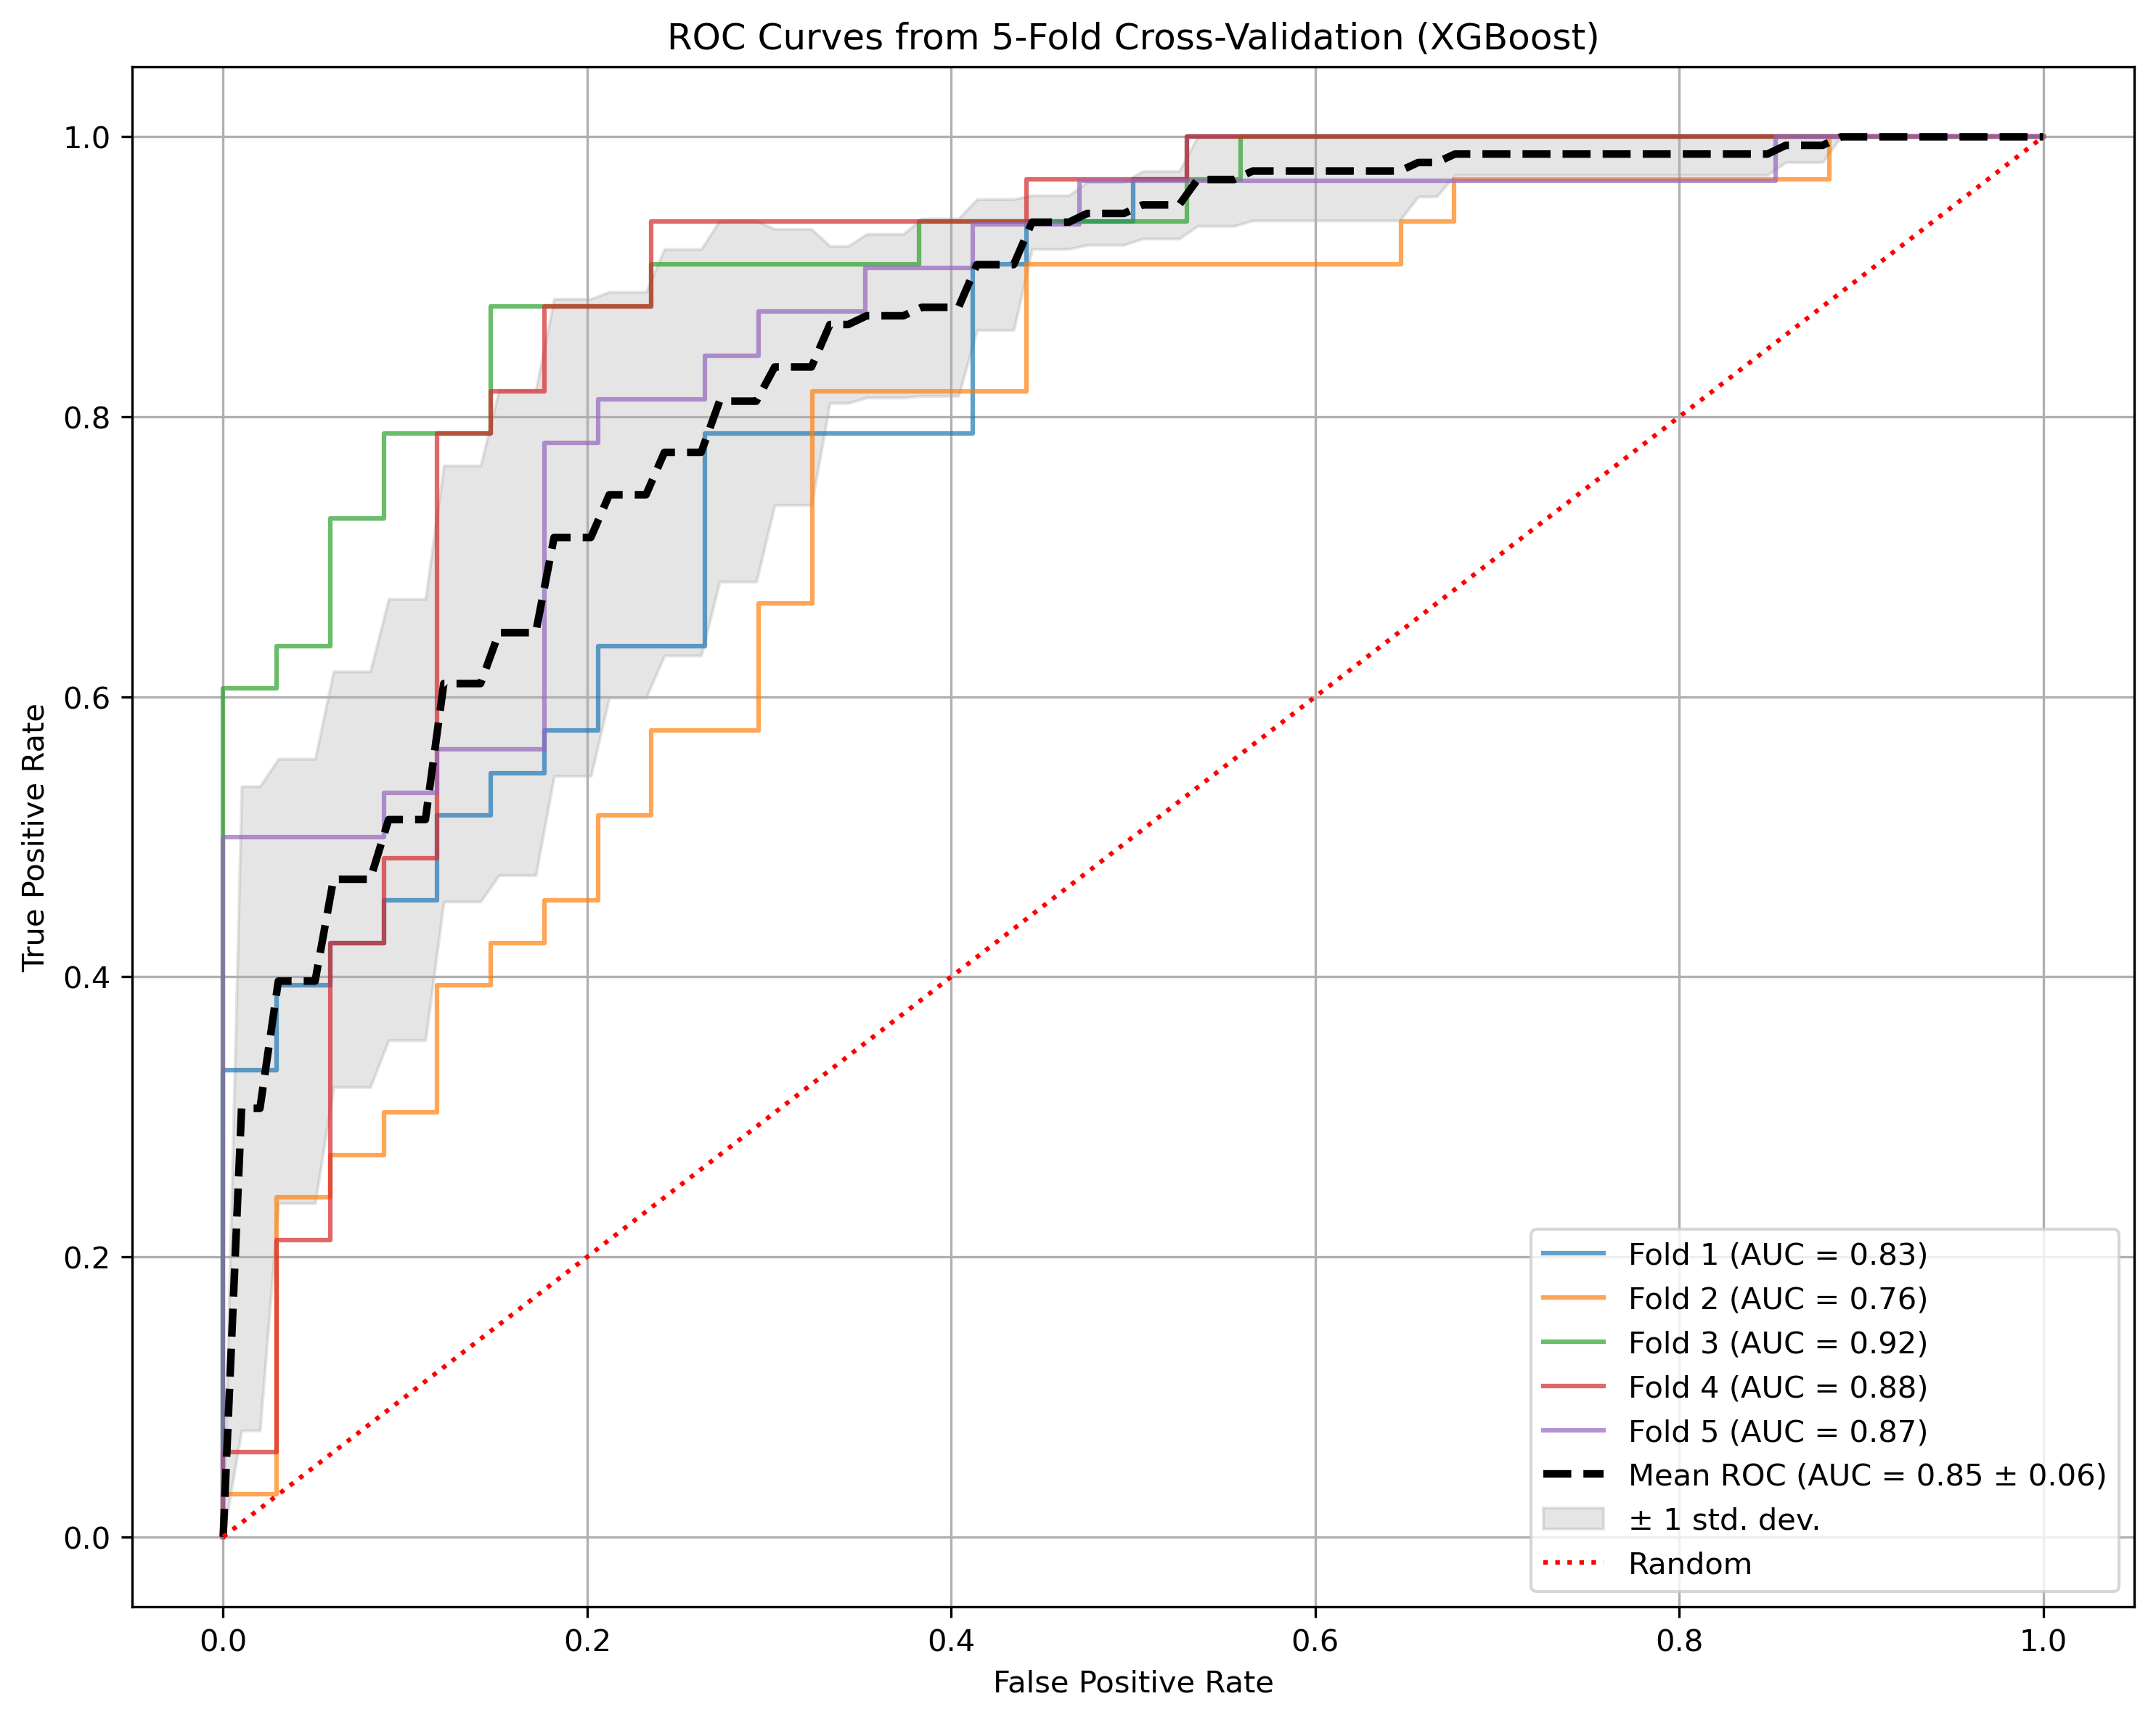


Mean AUC: 0.851 (±0.055)


In [25]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

classifier = XGBClassifier(
    learning_rate=0.05,
    max_depth=10,
    n_estimators=300,
    subsample=0.6,
    colsample_bytree=0.8,
    eval_metric='logloss',
    use_label_encoder=False,  # for xgboost <2.0 to suppress warning
    random_state=42
)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 8), dpi=300)

for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    classifier.fit(X.iloc[train_idx], y.iloc[train_idx])
    y_prob = classifier.predict_proba(X.iloc[test_idx])[:, 1]

    fpr, tpr, _ = roc_curve(y.iloc[test_idx], y_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

    plt.plot(fpr, tpr, lw=1.5, alpha=0.7, label=f"Fold {i+1} (AUC = {roc_auc:.2f})")

# Mean ROC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='black', linestyle='--',
         label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})", lw=2.5)

# ±1 std band
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2, label=r'± 1 std. dev.')

# Random line
plt.plot([0, 1], [0, 1], linestyle=':', color='red', label='Random', lw=1.5)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves from 5-Fold Cross-Validation (XGBoost)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\nMean AUC: {mean_auc:.3f} (±{std_auc:.3f})")